# Exploratory Data Analysis: Uncovering the Drivers of California House Values


## Section 0: Executive Summary & Key Findings
This analysis explores the key drivers of California house values to inform the development of a predictive machine learning model. This summary provides a high-level overview of the primary findings and actionable recommendations for both business strategy and the subsequent modeling phase.

## 0.1 The Business Problem
For a real estate investment firm, accurately predicting property values is the cornerstone of a successful investment strategy. Overpaying for an asset directly impacts profitability, while undervaluing a potential purchase can lead to missed opportunities. The goal of this project is to develop a machine learning model that can provide a reliable and data-driven estimate of a property's value based on its features (like location, age, and size) and local census data. This model will serve as a key tool to help our investment team identify undervalued properties and make more informed acquisition decisions in the California market.

## 0.2 Summary of Key Findings
- **Location is the Dominant Driver of Value:** The analysis unequivocally shows that a property's value is most strongly determined by its geographical location. Districts near the coast, particularly those 'NEAR BAY,' command significantly higher median values than 'INLAND' districts. Proximity to major economic hubs (identified via clustering) is a key indicator of high value.
- **Median Income is the Strongest Single Predictor:** After location, the median income of a district has the strongest positive linear relationship with median house value. This confirms that local economic health is a critical factor in property valuation.
- **Engineered Ratios Outperform Raw Counts:** Simple counts like total_rooms are less predictive than engineered ratios. For instance, the proportion of bedrooms to total rooms (bedrooms_ratio) provided a stronger signal, suggesting that the layout and type of housing stock are more influential than raw size alone.
- **Critical Data Limitation Identified:** The dataset has a significant price cap at $500,001, affecting nearly 5% of properties. This "censored data" will limit the final model's ability to accurately predict values for high-end real estate, a crucial constraint for investment strategy.

## 0.3 Recommended Action Plan
**For the Modeling Team:**

  1. **Proceed with the Preprocessing Blueprint:** Immediately implement the detailed preprocessing pipeline outlined in Section 4.3. This plan is designed to handle data skewness, multicollinearity, and to leverage the powerful new geographic and ratio-based features.  
  2. **Address the Price Cap:** As a primary modeling step, the districts with capped house values ($500,001) should be removed from the training set to prevent the model from learning a biased, artificial price ceiling.  
  3. **Develop and Evaluate Competing Models:** Systematically build, train, and evaluate the three candidate models (Linear Regression, Random Forest, Gradient Boosting) using rigorous cross-validation to identify the most accurate and reliable predictor.

**For Business & Data Stakeholders:**

  1. **Acknowledge Model Limitations:** Communicate to the investment team that the resulting model will be most reliable for properties valued below ~$450,000. A separate strategy or manual analysis may be required for the high-end market due to the data cap.
  2. **Enhance Future Data Collection:** Recommend that the data engineering team investigate adding a persistent unique identifier (e.g., census_block_id) to future data pulls to enable more robust data enrichment and time-series analysis.

## 1. Data Loading & Integrity Audit
### 1.1 Purpose
The foundation of any reliable analysis is a clean and well-understood dataset. This section outlines the initial data loading process and a systematic integrity audit performed on the California Housing dataset. We will identify and remediate any structural issues, incorrect data types, or missing values to ensure the data is robust and ready for analysis.

### 1.2 Library Imports and Environment Setup
**Objective:** To import all necessary libraries for data manipulation, analysis, and visualization, and to configure a professional and consistent visual theme for all plots in this notebook.

In [1]:
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent.resolve()
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.append(str(PROJECT_ROOT / "src"))
os.chdir(PROJECT_ROOT)

import matplotlib.pyplot as plt  # noqa: E402
import numpy as np  # noqa: E402
import pandas as pd  # noqa: E402
import seaborn as sns  # noqa: E402
from IPython.display import display  # noqa: E402
from matplotlib.container import BarContainer #  noqa: E402
from sklearn.cluster import KMeans  # noqa: E402
from sklearn.compose import make_column_selector  # noqa: E402
from sklearn.metrics.pairwise import rbf_kernel  # noqa: E402
from sklearn.model_selection import train_test_split  # noqa: E402

from california_housing.components.data_ingestion import DataIngestion  # noqa: E402
from california_housing.components.data_transformer import (  # noqa: E402
    create_preprocessing_pipeline,  # noqa: E402
)
from california_housing.core.config import ConfigurationManager  #noqa: E402

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported and environment configured successfully.")

Libraries imported and environment configured successfully.


### 1.3 Data Ingestion
**Objective:** To load the raw dataset into a Pandas DataFrame and perform a "first glance" inspection.

In [2]:
# --- Connect to the database and load data ---
try:
    # 1. Initialize the central configuration engine
    config_manager = ConfigurationManager()
    
    # 2. Extract specific ingestion settings and instantiate the component
    ingestion_config = config_manager.get_data_ingestion_config()
    ingestor = DataIngestion(config=ingestion_config)

     # 3. Retrieve raw dataset from the source (SQLite)
    df_raw = ingestor.get_data()
    
    # 4. Create an independent copy for exploration
    df_eda = df_raw.copy()

    # 5. Sanity Check / Visual Audit
    print("Data loaded successfully")
    print(f"Shape of data: {df_eda.shape}")

    # Display the first 5 rows to visually inspect the features and data format
    print("First 5 rows of dataset")
    display(df_eda.head())

except Exception as e:
    print(f"An error occured when loading the data: {e}")
    raise

Data loaded successfully
Shape of data: (20640, 10)
First 5 rows of dataset


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 1.4 Structural and Quality Audit
**Objective:** To programmatically assess the dataset's structure (shape, data types) and quality (missing values, duplicates). This is the core of our audit.

In [3]:
# --- Strutural Audit ---
print("Dataframe Structural Information")
print(df_eda.info())

Dataframe Structural Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [4]:
# --- 2. Quality Audit: Missing Values ---
print("\nMissing Values per Columns:")
missing_values = df_eda.isnull().sum()
display(missing_values[missing_values>0])


Missing Values per Columns:


total_bedrooms    207
dtype: int64

In [5]:
# --- Quality Audit: Duplicate Records ---

print(f"\nNumber of duplicate rows found: {df_eda.duplicated().sum()}")


Number of duplicate rows found: 0


**Audit Findings:**

**Structure:** The dataset contains 20640 entries and 10 columns.  
**Data Types:** Only `ocean_proximity` is an object type. All other types are float64.  
**Identifier:** The dataset lacks a persistent unique identifier for each district (e.g., a census block ID). For the purpose of this aggregate analysis, the default row index is sufficient. However, this is a noteworthy limitation for future work, as it would complicate joining this dataset with external time-series data or other demographic sources. This should be considered for any future data enrichment strategies.  
**Missing Values:** Minimal missing data overall—only 207 entries (~1%) in `total_bedrooms`. All other columns are fully populated (20,640 non-nulls). This suggests high data quality, with imputation feasible for the affected column.  
**Duplicates:** No duplicate rows were found (verified via `df_eda.duplicated().sum())`, indicating strong data integrity with no redundant records.  

### 1.5 Data Remediation
**Objective:** To systematically address the issues uncovered during the audit. This cleaning process ensures all features are in a usable and correct state for analysis

The audit has revealed a single data quality issue: the `total_bedrooms` column contains 207 missing values. All other columns are complete and have appropriate data types.

Our remediation will focus on addressing these missing values. A common and robust strategy is to use the median of the column. Given that only ~1% of the total_bedrooms data is missing, the choice of imputation strategy is unlikely to significantly impact model performance, making the simple and robust median the most appropriate and efficient choice. The median is preferred over the mean as it is less sensitive to outliers, which are common in real estate and census data.

In [6]:
# 1. Impute missing `total_bedrooms`
# Using median imputation as it's robust to outliers and skewness in housing data (e.g., room counts can be right-skewed)
median_bedrooms = df_eda['total_bedrooms'].median()
df_eda['total_bedrooms'] = df_eda['total_bedrooms'].fillna(median_bedrooms)
print(f"Action: Missing 'total_bedrooms' imputed with median value ({median_bedrooms}). "
      f"Remaining missing values: {df_eda['total_bedrooms'].isnull().sum()}"
    )

# No other remediation needed: Data types are already correct, no duplicates or non-predictive identifiers to drop.

# 2. Final Verification
print("\nFinal Dataframe Information after Remediation:")
df_eda.info()

Action: Missing 'total_bedrooms' imputed with median value (435.0). Remaining missing values: 0

Final Dataframe Information after Remediation:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### 1.6 Section Conclusion
The data ingestion and initial audit phase is now complete. The dataset, consisting of 20,640 rows and 10 columns, was successfully loaded. The primary remediation action was the imputation of 207 missing total_bedrooms values using the column median (435.0). All data types are now appropriate for analysis, and no duplicate records were found. The dataset is confirmed to be clean and structurally sound, providing a reliable foundation for the subsequent exploratory analysis.

## 2. Univariate Analysis: Profiling the Housing Districts
### 2.1 Purpose
The objective of this section is to develop a foundational understanding of the California housing districts by analyzing each key feature in isolation. We will examine the distribution and characteristics of our target variable (median_house_value), as well as our primary numeric and categorical predictors. This individual feature analysis is crucial for identifying fundamental data characteristics, such as feature skewness, potential capping (e.g., in the target), and imbalances, which will directly inform our data preprocessing and modeling strategy.

### 2.2 Target Variable Analysis: `median_house_value`
**Objective:** To understand the overall distribution of median house values in Californian districts, which is the central focus of our prediction task.

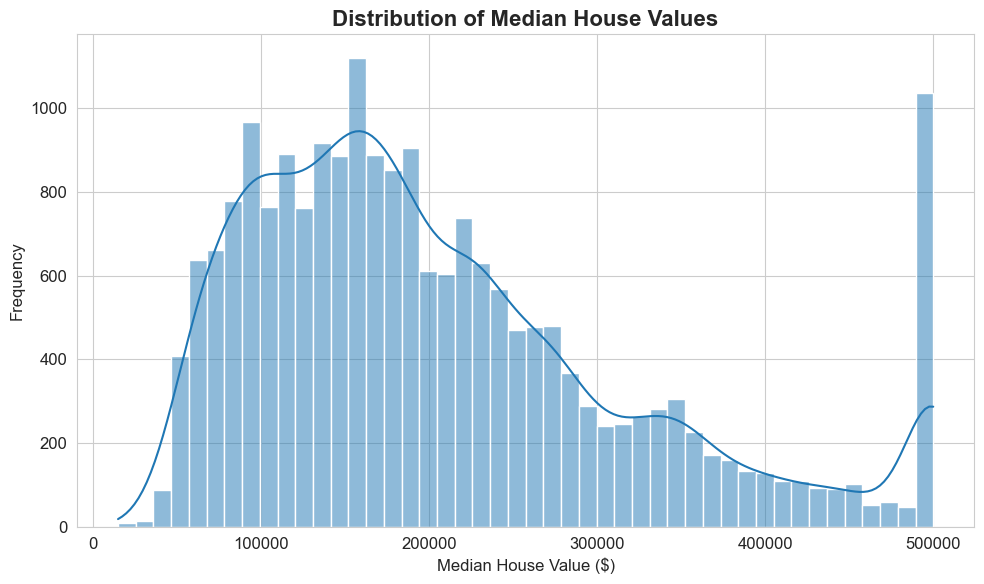

In [7]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10,6))

# Plot the histogram on the explicit axes
sns.histplot(data=df_eda, x="median_house_value", bins="auto", kde=True , ax=ax)

# Set title and labels via the axes object
ax.set_title("Distribution of Median House Values", fontsize=16, fontweight="bold")
ax.set_xlabel("Median House Value ($)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

In [8]:
# Show the counts of the most common values in the column
print("Top 5 most frequent median house values:")
display(df_eda['median_house_value'].value_counts().head(5))

# Programmatically determine the capped value and its impact
capped_value = df_eda['median_house_value'].max()
capped_count = (df_eda['median_house_value'] == capped_value).sum()
total_count = len(df_eda)
capped_percentage = (capped_count / total_count) * 100

print(f"\nConfirmed Capped Value: {capped_value}")
print(f"Number of districts at capped value: {capped_count}")
print(f"Percentage of districts at capped value: {capped_percentage:.1f}%")

Top 5 most frequent median house values:


median_house_value
500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
Name: count, dtype: int64


Confirmed Capped Value: 500001.0
Number of districts at capped value: 965
Percentage of districts at capped value: 4.7%


**Analysis & Implications:**

**Business Insight:** "The distribution of median house values is right-skewed, with a prominent peak around 100,000– 200,000. A critical finding is the artificial cap at the maximum value of at least 500,001. Higher-value districts are less common, with most districts falling in the mid-range."

**Engineering Implication:** "The right-skew and, more importantly, the data censoring at $500,000 will prevent any standard regression model from predicting values in this upper range. For modeling, we should consider either removing these capped districts or applying transformations (e.g., logarithmic) to normalize the distribution. This censoring will also bias evaluation metrics like RMSE, so we may prioritize models robust to skewed targets, such as tree-based regressors."

### 2.3 Numeric Feature Analysis 
Objective: To understand the distribution, central tendency, and spread of our key continuous variables (longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income).

Descriptive Statistics for Numeric Features:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


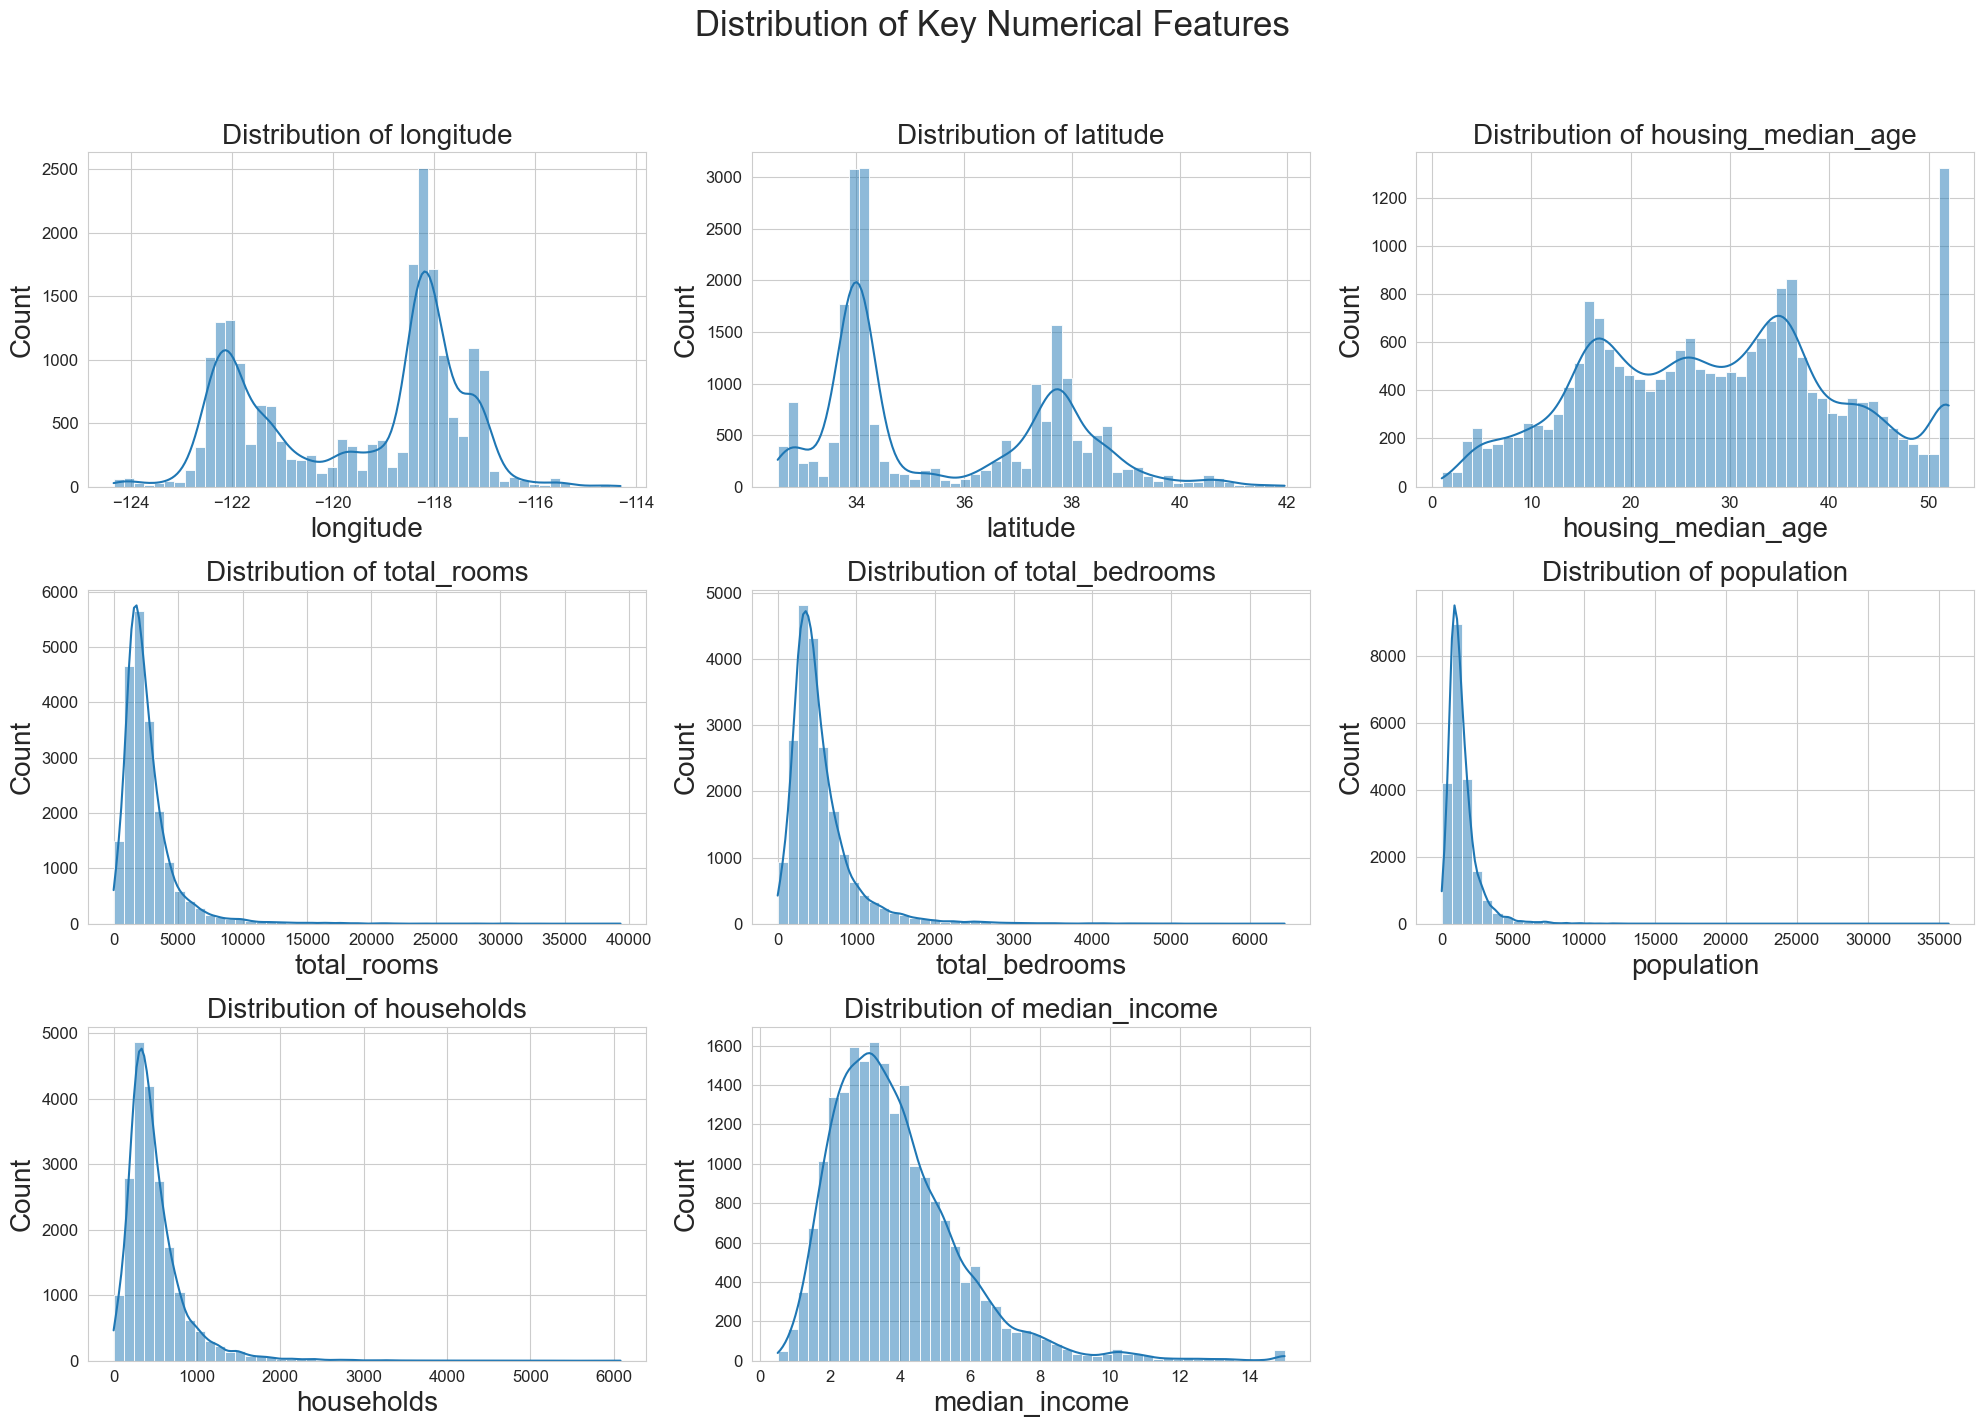

In [9]:
# Create the selector (excludes object/categorical columns)
numerical_selector = make_column_selector(dtype_exclude=np.dtype("object"))

# Apply to DataFrame to get list of numerical column names
numerical_features = numerical_selector(df_eda)

# Define the target variable
target = 'median_house_value'

# The target variable was analyzed separately.
# We remove it from this list to focus only on the predictor features.
if target in numerical_features:
    numerical_features.remove(target)

# --- Statistical Summary ---
print("Descriptive Statistics for Numeric Features:")
display(df_eda[numerical_features].describe())

# --- Distribution Plots ---
fig, axes = plt.subplots(ncols=3, nrows=3,figsize=(20,15))
fig.suptitle("Distribution of Key Numerical Features", fontsize=25)

axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.histplot(x=df_eda[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=20)
    axes[i].set_xlabel(col, fontsize=20)
    axes[i].set_ylabel('Count', fontsize=20)

# Hide the empty subplot (since we have 8 features, one axis will be unused)
axes[-1].axis("off")

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

**Analysis & Implications:**

**Business Insight:** Longitude and latitude show geographic clustering, reflecting California's coastal and inland districts. Housing_median_age is capped at 52 years, with a peak around 30–40 years, indicating many mid-century homes. Features like total_rooms, total_bedrooms, population, and households are heavily right-skewed, suggesting a mix of small and very large districts (e.g., urban vs. rural). Median_income also shows right-skew, with most districts in the lower to middle income brackets.

**Engineering Implication:** The right-skew in features like total_rooms, population, and median_income indicates they will be powerful predictors but may require logarithmic transformation (e.g., np.log1p) in the preprocessing pipeline to improve normality, especially for linear models. Capping in housing_median_age (at 52) suggests data artifacts; we may need to handle this as a categorical or binned feature. Geographic features (longitude, latitude) have multimodal distributions, hinting at natural clusters—feature engineering (e.g., distance to coast or cities) could enhance their utility.

### 2.3.1 Preparing for a Representative Train-Test Split: Stratifying by Income
**Objective:** Based on domain knowledge, median_income is expected to be a critical predictor of house values. To ensure our model is trained and evaluated on data that accurately reflects the full spectrum of income levels, it is essential to use **stratified sampling** for our train-test split. A purely random split could lead to a non-representative test set, giving us a misleading evaluation of our model's performance.

To facilitate this, we will engineer a new categorical feature, income_cat, by discretizing median_income into five distinct income brackets. The bins were carefully chosen to group the continuous variable into meaningful economic tiers and to ensure each stratum contains a sufficient number of samples, preventing undersampling of rare high or low-income districts."

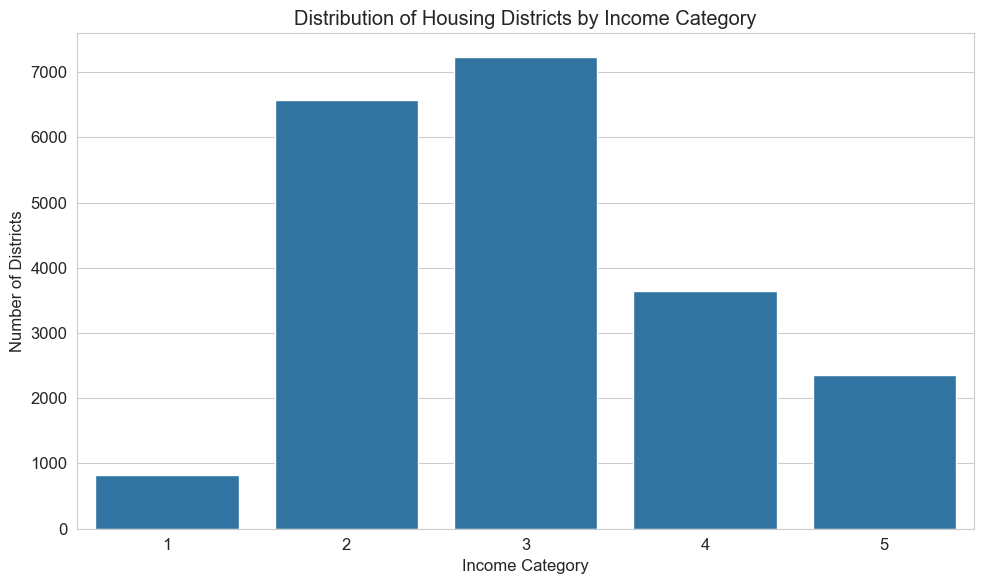

In [10]:
# Create the income categories
df_eda["income_cat"] = pd.cut(
    x=df_eda["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
)

# --- Visualize the new income categories ---
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x='income_cat', data=df_eda, ax=ax)
ax.set_title('Distribution of Housing Districts by Income Category')
ax.set_xlabel('Income Category')
ax.set_ylabel('Number of Districts')

plt.tight_layout()
plt.show()

**Analysis & Implications:**  
The plot shows that the majority of districts fall into categories 2 and 3. This distribution highlights the importance of our decision to stratify; a random split might accidentally undersample the rarer high-income districts. This income_cat feature is now ready to be used to create a representative train-test split before we proceed with modeling.

### 2.4 Categorical Feature Analysis
Objective: To understand the composition of housing districts across the key categorical feature (ocean_proximity). We will first assess cardinality (the number of unique values) to plan our encoding strategy.

In [11]:
# --- Cardinality Check ---
categorical_features = ["ocean_proximity"] #Only one categorical feature
print("Cardinalty of Categorical Feature:")
print(df_eda[categorical_features].nunique())

Cardinalty of Categorical Feature:
ocean_proximity    5
dtype: int64


In [12]:
# --- Value Counts for Detailed Insights ---
print("Value Count for ocean proximity:")
print(df_eda["ocean_proximity"].value_counts())

Value Count for ocean proximity:
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


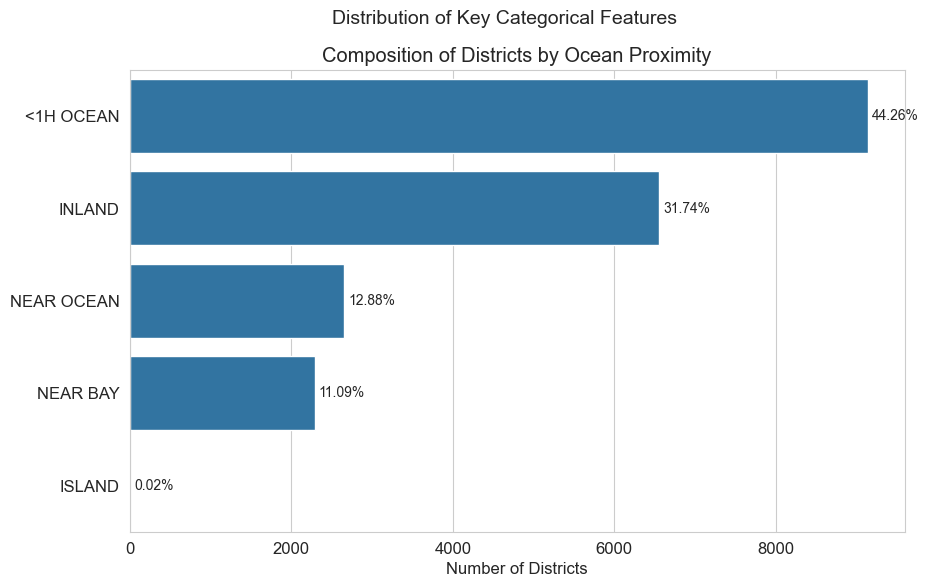

In [13]:
# --- Distribution of Key Categories --- 
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle("Distribution of Key Categorical Features", fontsize=14)

# Plotting horizontally for better label readability
sns.countplot(y="ocean_proximity", data=df_eda, order=df_eda["ocean_proximity"].value_counts().index, ax=ax)
ax.set_title("Composition of Districts by Ocean Proximity")
ax.set_xlabel("Number of Districts")
ax.set_ylabel("")

# --- Annotation Code for Percentages ---
total = len(df_eda)
for container in ax.containers:
    if isinstance(container, BarContainer):
        # Generate labels automatically based on the width (count)
        labels = [f"{(v.get_width() / total)*100:.2f}%" for v in container]
        
        # Use the built-in bar_label utility
        ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontsize=10)

plt.show()

**Analysis & Implications:**

**Business Insight:** The majority of districts (44.3%) are '<1H OCEAN' (near the coast but not directly on it), followed by 'INLAND' (31.7%). 'NEAR OCEAN' and 'NEAR BAY' make up smaller portions, with 'ISLAND' being extremely rare (only 5 districts, or 0.0% when rounded). This reflects California's geography, where proximity to water likely influences house values significantly.

**Engineering Implication:** The single categorical feature has low cardinality (5 unique values). This is ideal, as it means we can confidently use One-Hot Encoding in our pipeline without risking a "curse of dimensionality" from an explosion in the number of features. The severe imbalance (e.g., only 5 'ISLAND' districts) is a statistical outlier (N=5). To prevent model instability and potential stratification failures, this category will be consolidated into 'NEAR OCEAN' via a stateless CategoryMerger transformer.  This consolidates the signal (high-value, water-adjacent) and prevents the model from seeing a sparse column with only a few non-zero entries.

## 3. Bivariate & Multivariate Analysis: Discovering the Drivers of Median House Value
### 3.1 Purpose
Having profiled the individual features, we now move to the core of our analysis: uncovering the relationships between features and, most critically, their relationship with our target variable, Median House Value. This section is designed to directly answer the central question: "What are the key drivers of housing prices in California districts?" The insights generated here will form the basis of our predictive model and guide our feature engineering efforts.

### 3.2 Numeric Feature Correlation
**Objective:** To conduct a "quick scan" of the linear relationships between all numeric variables. This helps in identifying strong potential predictors for the target variable (median_house_value) and, crucially, in detecting multicollinearity between predictor variables.

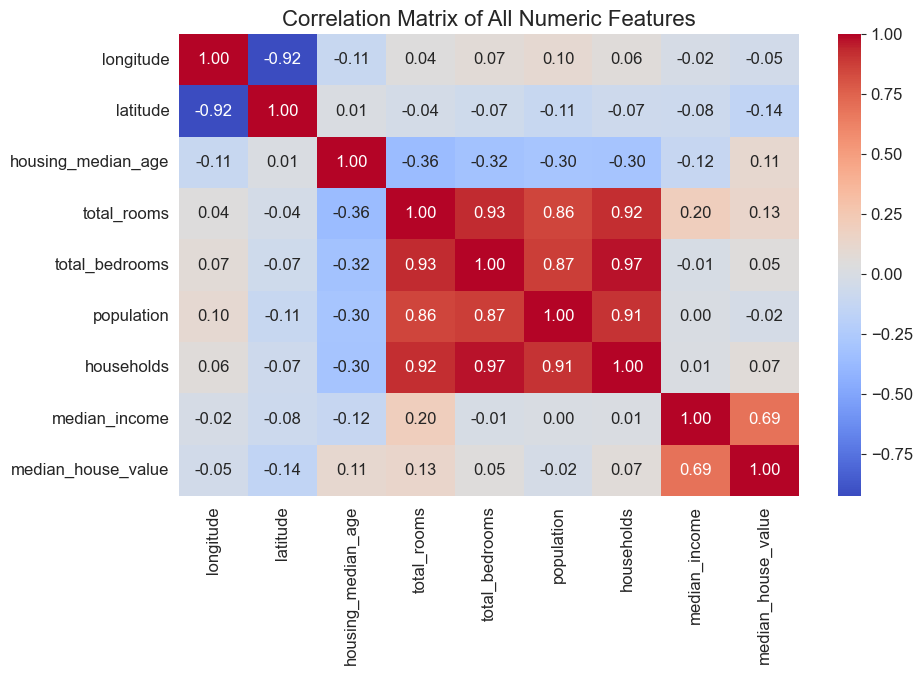

In [14]:
corr_matrix = df_eda.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)

ax.set_title('Correlation Matrix of All Numeric Features', fontsize=16)
plt.show()

**Analysis & Implications:**

**Identifying Predictors:** The row/column for median_house_value immediately stands out. The bright square at the intersection with median_income (0.69) confirms it is the strongest positive linear predictor.  
**Engineering Implication (Multicollinearity):** There is very strong positive correlation between total_bedrooms, households, total_rooms, and population. For instance, total_bedrooms and households have a correlation of 0.98. This is logical: districts with more households tend to have more people and more rooms. This high multicollinearity is a critical observation for modeling. While tree-based models are robust to it, linear models (like Logistic Regression) would be negatively affected. This justifies our later step of engineering ratio-based features.

### 3.3 Scatter Matrix Deep Dive on Key Features
**Objective:** The heatmap quantified the strength of linear correlations. Now, we use a scatter matrix to visually inspect the nature of these relationships for the most promising features identified (`median_income`, `total_rooms`, `housing_median_age`).

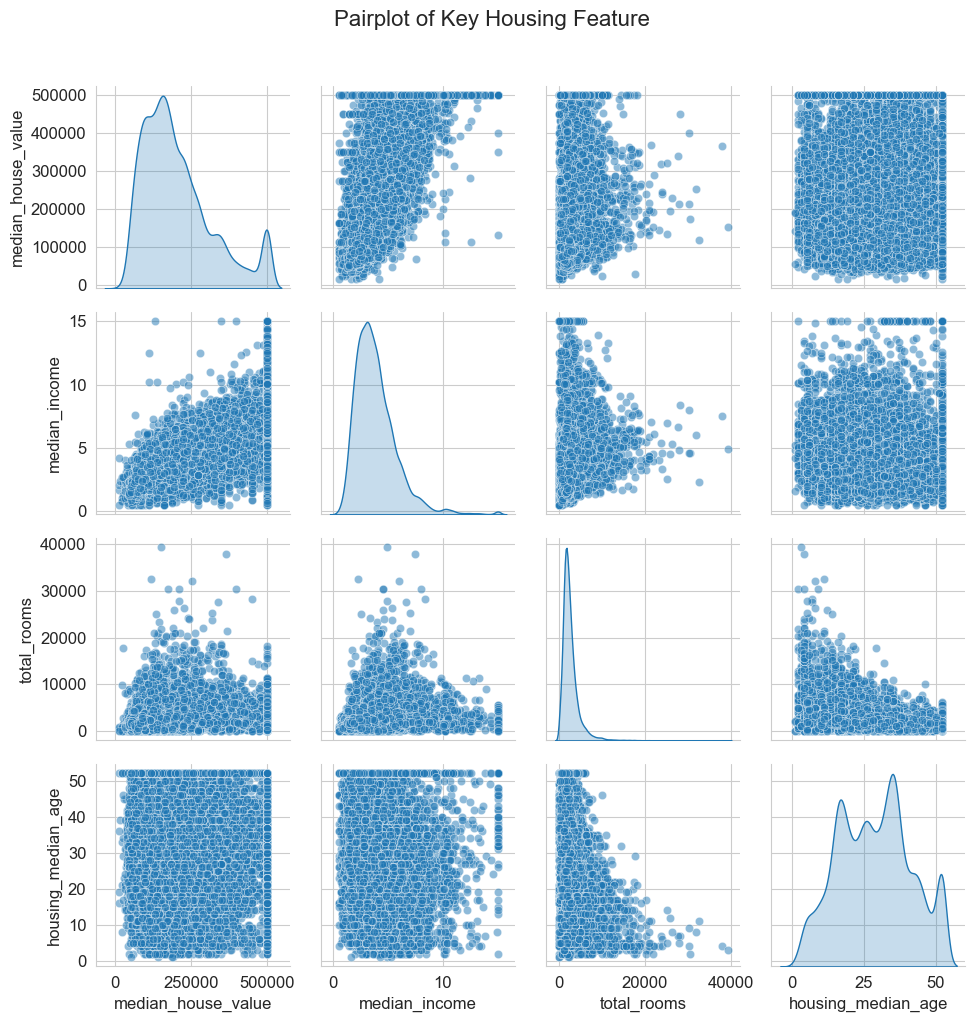

In [15]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

sns.pairplot(df_eda, vars=attributes, diag_kind='kde', plot_kws={'alpha':0.5}, height=2.5)
plt.suptitle('Pairplot of Key Housing Feature', y=1.02, fontsize=16)

plt.tight_layout()
plt.show()

**Analysis & Implications:**

**Business Insight:** This confirms the strong positive trend between median_income and median_house_value. However, the scatter matrix reveals critical details the heatmap cannot:
- **Price Capping:** There is a clear price cap at $500,000, visible as a horizontal line in the top row pf the plots. Other, less obvious lines appear at 450,000 and $350,000.
- **Tail-Heavy Distributions:** The histograms on the diagonal confirm that features like total_rooms are heavily skewed to the right.  

**Engineering Implication:** The data capping is a significant finding. For the model to predict values above $500k, we might need to remove these capped districts from the training data. The skewed distributions reinforce the need for data transformations (e.g., logarithms) to help some models perform better.

### 3.4 Hypothesis-Driven Feature Engineering & Correlation
**Objective:** To test the hypothesis that raw counts (like total_rooms) are less predictive than per-household ratios. We will engineer new features and re-evaluate their correlation with the median house value. This is a key step in creating more powerful, context-rich variables.

In [16]:
# Create new feature by combining existing ones
df_eda["rooms_per_house"] = df_eda["total_rooms"] / df_eda["households"]
df_eda["bedrooms_ratio"] = df_eda["total_bedrooms"] / df_eda["total_rooms"]
df_eda["people_per_house"] = df_eda["population"] / df_eda["households"]

# Recalculate the correlation matrix with new features
corr_matrix = df_eda.corr(numeric_only=True)
print("Correlation with Median House Value:")
print(corr_matrix["median_house_value"].sort_values(ascending=False))

Correlation with Median House Value:
median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049457
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.233303
Name: median_house_value, dtype: float64


**Analysis & Implications:**

**Business Insight (Key Finding):** This experiment is highly successful. The engineered bedrooms_ratio feature shows a negative correlation of -0.26 with the target, which is significantly more predictive and informative than its component features, total_bedrooms (0.05) and total_rooms (0.13). This provides a valuable insight: districts with a higher proportion of bedrooms to total rooms (suggesting smaller individual rooms) tend to have lower house values.

**Engineering Implication:** This confirms that feature engineering is essential. The new ratio features, particularly bedrooms_ratio and rooms_per_house, are more informative than the original raw counts and should be prioritized for our model.

### 3.5 Categorical Features vs. Median House Value
**Objective:** To determine which geographical segments, as defined by the ocean_proximity feature, have the highest median house values.

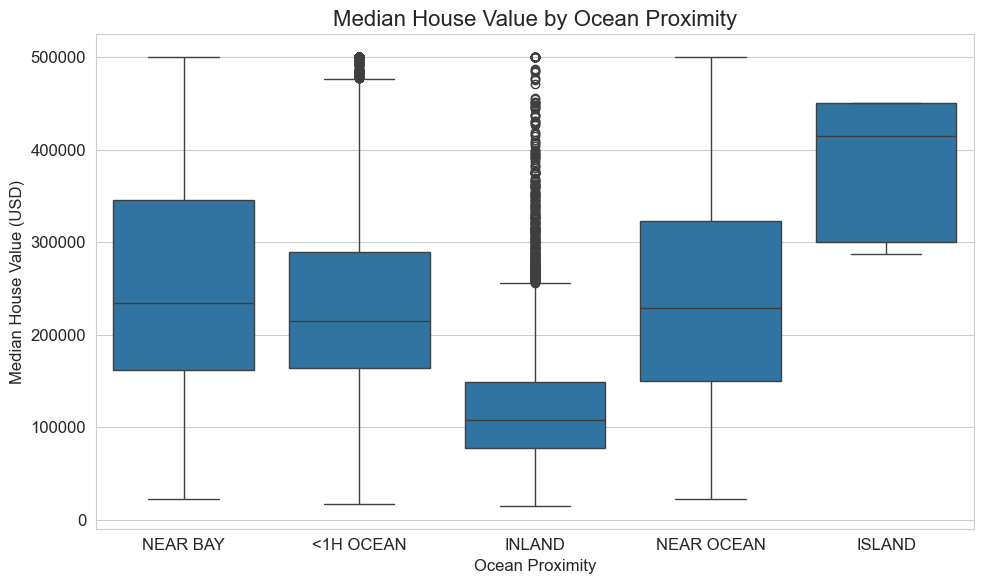

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df_eda, x="ocean_proximity", y="median_house_value", ax=ax)

ax.set_title("Median House Value by Ocean Proximity", fontsize=16)
ax.set_xlabel("Ocean Proximity", fontsize=12)
ax.set_ylabel("Median House Value (USD)", fontsize=12)

plt.tight_layout()
plt.show()

**Analysis & Implications:**

**Business Insight:** The findings are stark and highly actionable:

- **Proximity to Water Matters:** Districts that are 'NEAR BAY' have the highest median house value, followed closely by 'NEAR OCEAN' and '<1H OCEAN'.
- **Inland Penalty:** 'INLAND' districts have a significantly lower median house value, confirming that location relative to the coast is a major price driver.
- **Island Anomaly:** The 'ISLAND' category shows a high median value but has very few data points, indicating it's an outlier that may require special handling or could be excluded due to its rarity.

### 3.6 Multivariate Visualization
**Objective:** To synthesize multiple variables into a single visualization to uncover a more holistic understanding of housing price drivers. Here, we investigate the combined effect of geographical location (longitude/latitude), population density, and median house value.

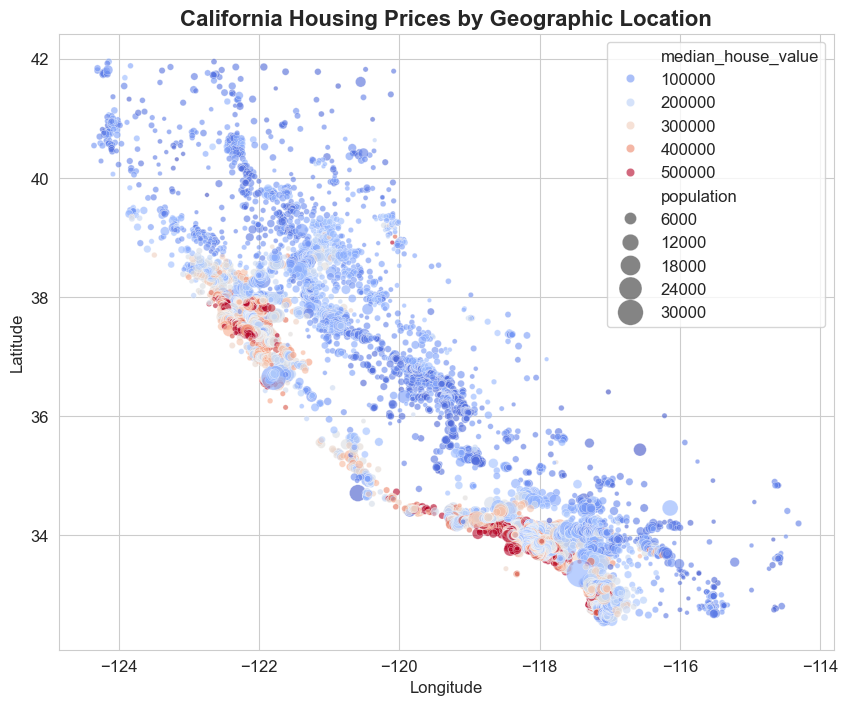

In [18]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(
    data=df_eda,
    x="longitude",
    y="latitude",
    size="population",
    hue="median_house_value",
    sizes=(10, 400),
    palette="coolwarm",
    alpha=0.6,
    ax=ax,
)

ax.set_title("California Housing Prices by Geographic Location", fontsize=16, fontweight="bold")
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

plt.show()

**Analysis & Implications:**

**Business Insight:** This rich visualization provides the definitive answer to what drives high prices. It's not just income or room count; it's overwhelmingly about location and proximity to the coast. The most expensive areas (red dots) are tightly clustered in coastal regions, especially the San Francisco Bay Area and Southern California (around Los Angeles and San Diego). Population density (represented by circle size) is also higher in these expensive areas, but location is the more dominant visual pattern. High-value areas are a combination of desirable location and high population.

**Actionable Conclusion:** This is a powerful, specific insight. Any successful model must have a sophisticated understanding of geography. The simple ocean_proximity feature is a good start, but this plot strongly suggests that creating more complex geographical features will provide a significant boost to model accuracy. This is a prime example of how data visualization directly informs feature engineering strategy.

### 3.7 Advanced Geospatial Analysis: Visualizing Cluster Hotspots
**Objective:** To visually validate our hypothesis that distinct geographical hotspots drive house values. To implement this, we will use K-Means clustering. We make two strategic choices to enhance the relevance of the resulting features:

- **Number of Clusters (K=10):** This was chosen heuristically to approximate the number of major, distinct metropolitan and economic zones in California (e.g., the SF Bay Area, Greater LA, San Diego, Sacramento Valley). This parameter could be tuned during model optimization.
- **Value-Weighted Clustering:** Crucially, we employ a value-weighted K-Means by using median_house_value as the sample_weight. This forces the algorithm to place cluster centers not just in areas of high population density, but specifically in areas of high economic value. The resulting features will therefore measure proximity to key economic hubs, which we hypothesize is a stronger price driver than proximity to mere population centers.

**Disclaimer on Data Usage:** This visualization is performed on the **full dataset** for exploratory purposes to gain the best possible insight into the overall geographical patterns. In the final modeling pipeline (Section 4), the `KMeans` fitting will be performed **on the training set only** to prevent data leakage.

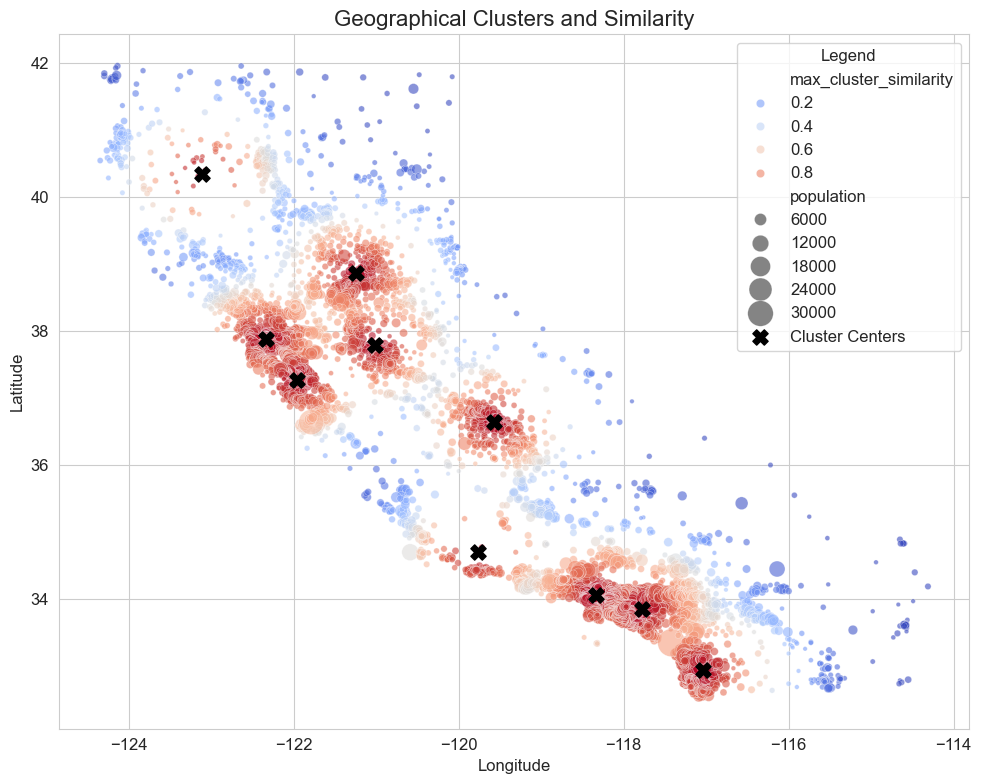

In [19]:
# Fit a temporary KMeans on the full dataset's coordinates
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
geo_features = df_eda[["longitude", "latitude"]]
kmeans.fit(geo_features, sample_weight=df_eda["median_house_value"])

# Get the coordinates of the centers from the fitted transformer
centers = kmeans.cluster_centers_

# Calculate similarities for visualization
similarities = rbf_kernel(geo_features, centers, gamma=1.0)

# Add the new feature to the original DataFrame
df_eda["max_cluster_similarity"] = similarities.max(axis=1)

# --- Create the Visualization ---
fig, ax = plt.subplots(figsize=(10, 8))

# Create the main scatter plot using Seaborn
sns.scatterplot(
    data=df_eda,
    x="longitude",
    y="latitude",
    size="population",
    hue="max_cluster_similarity", 
    sizes=(10, 400),
    palette="coolwarm",
    alpha=0.6,
    ax=ax,
    legend="auto"
)

# Plot the cluster centers on the SAME axes
# Use a standard Matplotlib scatter plot for the centers
ax.scatter(
    x=centers[:, 0], # Longitude is the first column
    y=centers[:, 1], # Latitude is the second column
    c="black",
    marker="X",
    s=120, # Control the size of the 'X' markers
    label="Cluster Centers",
)

# Customize and Show
ax.set_title("Geographical Clusters and Similarity", fontsize=16)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)
ax.legend(title="Legend") # Improve the legend

plt.grid(True)
plt.tight_layout()
plt.show()

**Analysis & Implications:**

**Business Insight:** The cluster centers (black 'X's) effectively act as data-driven definitions of major population/economic hubs. The "Max cluster similarity" (color scale) then measures how "close" each district is to one of these hubs. The map clearly shows that similarity scores are highest (red dots) around these centers, which aligns perfectly with our understanding of urban development and real estate value.

**Engineering Implication:** This is a powerful feature engineering technique. Instead of using raw latitude and longitude, we can now feed the model a set of "cluster similarity" scores. These features are more informative as they represent proximity to meaningful geographical centers, potentially providing a much stronger signal to the model than the original coordinates.

### 3.8 Conclusion & Transition to Modeling
Our exploratory analysis has provided a deep understanding of the data's structure and the key drivers of house value. We've confirmed that `median_income` and geographical location are paramount, and we've identified important feature characteristics (skewness, multicollinearity) and engineered more powerful ratio-based features.

The exploratory phase is now complete. Before we can finalize a precise blueprint for our machine learning pipeline, we must split our data into a training and a testing set. **From this point forward, all data-driven fitting and parameter learning (e.g., calculating cluster centers, fitting scalers) will be performed only on the training data to prevent data leakage and ensure a valid model evaluation.**

In [20]:
# --- Perform the Stratified Train-Test Split ---
# CRITICAL: We perform the split on the ORIGINAL, UNMODIFIED data (`df_raw`)
# to ensure the test set is pristine and untouched by any exploratory modifications.

# Create the stratification key directly on the raw DataFrame.
df_raw["income_cat"] = pd.cut(
    x=df_raw["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

# We use the 'income_cat' feature to ensure the income
# distribution is represented equally in both sets.
strat_train_set, strat_test_set = train_test_split(
    df_raw,
    test_size=0.2,
    stratify=df_raw["income_cat"],
    random_state=42,
)

# For the subsequent feature engineering steps, we will work with a copy of the training set.
housing = strat_train_set.copy()

# It's good practice to drop the stratification column after the split
# as it served its purpose.
for set_ in (housing, strat_test_set):
    set_.drop(columns=["income_cat"], inplace=True)

print("Data successfully split into training and testing sets.")
print(f"Training set shape: {housing.shape}")
print(f"Test set shape: {strat_test_set.shape}")

Data successfully split into training and testing sets.
Training set shape: (16512, 10)
Test set shape: (4128, 10)


##  Section 4: Conclusions & Blueprint for Modeling
### 4.1 Purpose
This concluding section synthesizes the key business and technical insights gathered throughout the Exploratory Data Analysis (EDA) of the California Housing dataset. We first summarize the definitive profile of high-value districts and then translate our findings into a precise, actionable blueprint for the preprocessing pipeline. This blueprint serves as the direct specification for the engineering phase, ensuring reproducibility and preventing data leakage by applying all fitting operations (e.g., clustering, scaling) on the training data only.

### 4.2 Summary of Key Findings
Our exploration has yielded several critical insights that will guide the modeling process:

- **High-Value District Profile:** High-value districts are characterized by high median_income, proximity to the coast ('NEAR BAY', '<1H OCEAN', 'NEAR OCEAN'), and higher population density. Districts with a higher bedrooms_ratio (more bedrooms relative to total rooms) tend to have lower values, indicating smaller or less desirable homes.

- **Feature Characteristics:** The target (`median_house_value`) and numeric features (e.g., `total_rooms`, `population`) are right-skewed with caps (e.g., $500,000, 52 years for `housing_median_age`). Missing values are minimal (1% in `total_bedrooms`). The categorical feature ocean_proximity has low cardinality (5 levels) but is imbalanced ('ISLAND' is rare).

- **Key Predictive Features:** `Median_income` (correlation 0.69) and ocean_proximity are the strongest predictors. Engineered features like bedrooms_ratio (-0.26) and rooms_per_house (0.14) outperform raw counts. Geographic clustering adds nuanced location-based signals.

- **Data Quality and Challenges:** Multicollinearity among size-related features (`total_rooms`, `total_bedrooms`, `households`, `population`; correlations >0.83), capping, and skewness require careful preprocessing. Stratified sampling on `income_cat` is essential to preserve income distribution.

### 4.3 Blueprint for Preprocessing Pipeline (ColumnTransformer Specification)

**Scope & Data Cleaning Strategy:**  
Before the data enters the transformation pipeline, we apply a strict cleaning filter. **Districts with capped values ($500,001) are removed entirely.** This ensures the model learns from authentic, uncensored market signals and prevents the artificial price ceiling from biasing our predictions for high-end properties.  

**Transformation Logic:**  
The following plan outlines the complete preprocessing strategy, designed to be implemented as a single, robust scikit-learn ColumnTransformer to prevent data leakage and ensure reproducibility. Informed by EDA insights (e.g., skewness in numerics from Section 2.3, low cardinality in categoricals from 2.4, and geographic multimodality from 3.7), features are grouped into three logical blueprints by type and processing needs. Each blueprint specifies sequential steps, tools, and justifications, with all fitting performed on the training data only.

**Note:** The geospatial pipeline uses the ClusterSimilarity transformer, prototyped in Section 3.7 to identify geographic hotspots (e.g., San Francisco, Los Angeles). To prevent data leakage, it is fitted on training data only, ensuring methodological rigor.

**Blueprint 1: Numerical & Engineered Features**
| Feature(s)                                                         | Characteristic Identified in EDA            | Chosen Strategy (Sequential)                                                           | Scikit-Learn Tool(s)                                                                                                         | Justification                                                                                                                                                                                   |
|--------------------------------------------------------------------|---------------------------------------------|----------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| median_income, total_rooms, total_bedrooms, population, households | Right-skewed, some missing (total_bedrooms) | 1. Median Imputation<br>2. Log Transform (np.log1p)<br>3. Standard Scaling                        | Pipeline([SimpleImputer(strategy="median"), FunctionTransformer(np.log1p), StandardScaler()])                                | Log transform (np.log1p) normalizes skewness and provides numerical safety against zero-valued entries by preventing infinite outputs (Section 2.3); imputation handles missing values (1.4); scaling for model stability.                                                                          |
| housing_median_age                                                 | Capped, not skewed                          | 1. Median Imputation<br>2. Standard Scaling                                            | Pipeline([SimpleImputer(strategy='median'), StandardScaler()])                                                               | No missing in training, but imputation ensures robustness; scaling for consistency.                                                                                                             |
| bedroom_ratio, rooms_per_house, people_per_house                   | Engineered, address multicollinearity       | 1. Median Imputation<br>2. RatioFeature<br>3. Median Imputation<br>4. Standard Scaling | Pipeline([SimpleImputer(strategy='median'), RatioFeature(col_a, col_b), SimpleImputer(strategy='median'), StandardScaler()]) | Pre-imputation prevents division errors; Ratios mitigate multicollinearity (Sec 3.2) and increase signal (Sec 3.4); Post-imputation handles zero-denominators; Scaling ensures model stability. |

**Blueprint 2: Categorical Features**
| Feature(s) | Characteristic Identified in EDA | Chosen Strategy (Sequential) | Scikit-Learn Tool(s) | Justification |
| :---: | :---: | :---: | :---: | :---: |
| ocean_proximity | Nominal, low cardinality (5), imbalanced (rare 'ISLAND' cat) | 1. Category Merging<br>2. Mode Imputation<br>3. One-Hot Encoding | Pipeline([CategoryMerger, SimpleImputer(strategy='most_frequent'), OneHotEncoder]) | Merges rare 'ISLAND' category to prevent overfitting (Sec 2.4); Imputation ensures robustness; One-Hot Encoding suitable for low cardinality. |

**Blueprint 3: Advanced Geospatial Features**
|      Feature(s)     |   Characteristic Identified in EDA   |                                Chosen Strategy (Sequential)                                |                                                Scikit-Learn Tool(s)                                               |                                    Justification                                   |
|:-------------------:|:------------------------------------:|:------------------------------------------------------------------------------------------:|:-----------------------------------------------------------------------------------------------------------------:|:----------------------------------------------------------------------------------:|
| latitude, longitude | Multimodal, strong geographic signal | 1. Median Imputation<br>2. Standard Scaling<br>3. ClusterSimilarity<br>4. Standard Scaling | Pipeline([SimpleImputer(strategy='median'), StandardScaler(), ClusterSimilarity(n_clusters=10, random_state=42)]) | Scaling ensures accurate KMeans clustering; similarities capture urban hubs (3.7). |

### 4.4 Prototyping & Validating the Preprocessing Pipeline
**Objective:** To validate our blueprint by creating an instance of the full preprocessing pipeline and applying it to the training data. This executable prototype serves three key purposes:

- **Validation:** Confirms that the ColumnTransformer and all custom transformers work together as designed.
- **Inspection:** Allows us to view the final, fully transformed data that the model will be trained on.
- **Reproducibility:** Provides a working, self-contained example of the entire preprocessing logic.  

In [21]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [22]:
# --- Instantiate and Fit the Full Pipeline on the Training Data ---

try:
    pipeline_config = config_manager.get_model_trainer_config().preprocessing
    random_state = config_manager.get_globals_config().random_state

    housing_features = housing.drop(columns=["median_house_value"])
    housing_labels = housing["median_house_value"].copy()

    preprocessor = create_preprocessing_pipeline(config=pipeline_config, random_state=random_state)

    housing_prepared = preprocessor.fit_transform(housing_features)
    assert isinstance(housing_prepared, pd.DataFrame), "Pipeline output should be a Pandas DataFrame."

    print(f"Shape of the prepared data: {housing_prepared.shape}")
    print("\nFirst 5 rows of prepared data:")
    display(housing_prepared.head())

except Exception as e:
    print(f"PIPELINE VALIDATION FAILED: {e}")
    raise

ClusterSimilarity.fit received y=None. Falling back to unweighted KMeans.


Shape of the prepared data: (16512, 23)

First 5 rows of prepared data:


,bedroom_ratio__total_bedrooms_per_total_rooms,rooms_per_house__total_rooms_per_households,people_per_house__population_per_households,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__cluster_0_similarity,geo__cluster_1_similarity,...,geo__cluster_5_similarity,geo__cluster_6_similarity,geo__cluster_7_similarity,geo__cluster_8_similarity,geo__cluster_9_similarity,cat__ocean_proximity__1H_OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_NEAR_BAY,cat__ocean_proximity_NEAR_OCEAN,remainder__housing_median_age
12655,-0.121122,0.017395,0.006223,0.876814,0.852802,0.939807,0.800912,-1.012598,-1.103178,1.150867,...,0.926087,0.932506,1.587901,2.180185,-1.094662,0.0,1.0,0.0,0.0,0.027564
15502,-0.810867,0.569256,-0.040811,0.974434,1.278834,0.797735,0.917052,1.324446,0.358871,-0.759245,...,-0.778581,-0.525206,-0.830543,-0.765827,0.914740,0.0,0.0,0.0,1.0,-1.722018
2908,-0.338273,-0.018024,-0.075371,-0.434286,-0.318385,-0.704456,-0.378893,-0.455795,0.185348,-0.719900,...,-0.632821,-0.524852,-0.505025,-0.710603,-0.268463,0.0,1.0,0.0,0.0,1.220460
14053,0.961205,-0.595140,-0.106803,0.280923,-0.119179,-0.300554,0.277348,-0.966587,0.075475,-0.759259,...,-0.778716,-0.525206,-0.830984,-0.765846,0.598628,0.0,0.0,0.0,1.0,-0.370069
20496,-0.474513,0.251241,0.006109,0.584959,0.730635,0.672024,0.529725,0.518914,1.012880,-0.754320,...,-0.751530,-0.525194,-0.775180,-0.760675,0.479738,1.0,0.0,0.0,0.0,-0.131489


**Analysis & Implications:**

**Validation:** The preprocessing pipeline executed successfully on the training data. This confirms that the `ColumnTransformer` is correctly configured and that all custom transformers (`RatioFeature`, `ClusterSimilarity`) and standard processing steps are working together as designed.

**Output Structure:** The output is a pandas DataFrame with **24 columns**, which is the expected result of our transformations. The original 9 predictor columns have been replaced by this new, richer feature set:
- **5 Log-Transformed & Scaled Features** (e.g., `log__median_income`)
- **3 Engineered Ratio Features** (e.g., `ratio__rooms_per_house`)
- **10 Geospatial Similarity Features** (e.g., `geo__cluster_0_similarity`)
- **5 One-Hot Encoded Categorical Features** (`from ocean_proximity`)
- **1 Standard Scaled Remainder Feature** (`remainder__housing_median_age`)

**Engineering Implication:**     This validated full_pipeline object is now a complete, leakage-free preprocessing tool. It has learned all necessary statistics (medians, means, standard deviations, cluster centers, etc.) exclusively from the training data. It is now ready to be used in the final model pipeline to transform the test set or any new data by simply calling its `.transform()` method, guaranteeing consistent and reproducible feature engineering.

### 4.5 Reference Implementation
To make this notebook a self-contained document, the source code for the key components of the preprocessing pipeline is included below for reference. This code is defined in the `src/california_housing/components/data_transformer.py` module and was imported at the beginning of this notebook.

**Custom Transformers (`FeatureNameSanitizer`, `ClusterSimilarity` and `RatioFeature`):**

The following defines the custom transformers used in the preprocessing pipeline:
*   **`FeatureNameSanitizer`**: Handles the sanitization of feature names (e.g., removing spaces/symbols) to ensure technical compatibility with downstream model frameworks.
*   **`ClusterSimilarity` & `RatioFeature`**: Encapsulate the complex logic for geospatial and interaction features.

Collectively, these components ensure that the pipeline is **robust, reproducible, and leakage-free** by centralizing the transformation logic into version-controlled classes.

``` python
# This is a Markdown code block, not an executable cell.
"""
Modular preprocessing and feature engineering engine.

This module provides custom Scikit-Learn transformers and a centralized factory
function to build the complete data transformation pipeline. It handles
imputation, scaling, encoding, and advanced geospatial/ratio-based engineering.
"""

import logging
import re
from typing import Literal, TypeAlias, cast

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.validation import check_is_fitted, validate_data  # type: ignore

from california_housing.core.config_definitions import (
    CategoryMergingConfig,
    PipelinePreprocessingConfig,
)

# Type alias for inputs that Scikit-Learn transformers accept
ArrayLike: TypeAlias = np.ndarray | pd.DataFrame

logger = logging.getLogger(__name__)

# =============================================================================
# CUSTOM TRANSFORMERS (Engineering Primitives)
# =============================================================================


class FeatureNameSanitizer(BaseEstimator, TransformerMixin):
    """
    Sanitize column names to ensure compatibility with downstream models.

    LightGBM and XGBoost often crash or produce warnings if feature names
    contain special characters (like '[' or '<') or spaces. This transformer
    ensures all feature names follow the 'snake_case' pattern.
    """

    def __init__(self) -> None:
        super().__init__()

    def fit(self, X: ArrayLike, y: pd.Series | None = None) -> "FeatureNameSanitizer":
        """Stateless transformer; returns self."""
        return self

    def transform(self, X: ArrayLike) -> pd.DataFrame:
        """Apply sanitized feature names to the input matrix, with fallback for RangeIndex columns."""
        if isinstance(X, pd.DataFrame):
            X_transformed = X.copy()
        else:
            X_transformed = pd.DataFrame(X)

        if isinstance(X_transformed.columns, pd.RangeIndex):
            logger.warning("No input columns provided; using default indexing.")
            input_cols = [f"feature_{i}" for i in X_transformed.columns]
        else:
            input_cols = X_transformed.columns.tolist()

        X_transformed.columns = self.get_feature_names_out(input_cols)
        return X_transformed

    def get_feature_names_out(
        self, input_features: list[str] | None = None
    ) -> list[str]:
        """Apply regex sanitization to replace non-alphanumeric characters with underscores."""
        if input_features is None:
            raise ValueError("input_features must be provided to get_feature_names_out")

        sanitized_feature = [
            re.sub(r"[^a-zA-Z0-9_]", "_", str(col)) for col in input_features
        ]
        return sanitized_feature

    def __sklearn_is_fitted__(self) -> bool:
        """Inform Scikit-Learn that this transformer is always ready."""
        return True


class CategoryMerger(BaseEstimator, TransformerMixin):
    """
    Merges specific categorical values into a single category.

    Useful for handling rare categories (e.g., merging 'ISLAND' into 'NEAR OCEAN')
    to prevent model instability or creation of sparse columns during One-Hot Encoding.
    It prioritizes explicit column name lookup to ensure safety.
    """

    def __init__(self, col: str, mapping: dict[str, str]) -> None:
        """
        Initialize the merger.

        Args:
            col (str): The name of the categorical column to modify.
            mapping (dict[str, str]): A dictionary where keys are the old values
                                      and values are the new replacement values.
        """
        super().__init__()
        self.col = col
        self.mapping = mapping

        self.col_idx_: int | None = None
        self.feature_names_in_: np.ndarray | None = None

    def fit(self, X: pd.DataFrame, y: pd.Series | None = None) -> "CategoryMerger":
        """
        Validate input and mark as fitted.

        This is a stateless transformer (it does not learn from data), but
        it validates that the input has the required structure.

        Args:
            X (pd.DataFrame): The training input samples.
            y (pd.Series | None): Ignored. Exists for compatibility.

        Returns:
            self: The fitted transformer.
        """
        _ = validate_data(self, X, dtype=None, ensure_min_features=1)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Apply the value mapping to the specified column.

        Args:
            X (pd.DataFrame): Input data. Must be a DataFrame to allow name-based lookup.

        Raises:
            TypeError: If X is not a pandas DataFrame.
            ValueError: If the target column is missing from X.

        Returns:
            pd.DataFrame: The transformed DataFrame with merged categories.
        """
        # 1. Enforce the Contract (Fail Fast)
        if not isinstance(X, pd.DataFrame):
            raise TypeError(
                f"CategoryMerger received {type(X)} but expects pd.DataFrame. "
                "Ensure this transformer is placed before steps that output NumPy arrays "
                "(e.g., before SimpleImputer)."
            )

        # 2. Check Existence
        if self.col not in X.columns:
            raise ValueError(f"Column '{self.col}' not found in input DataFrame.")

        X_out = X.copy()

        # 3. Apply Mapping
        X_out[self.col] = X_out[self.col].replace(self.mapping)

        return X_out

    def get_feature_names_out(
        self, input_features: list[str] | None = None
    ) -> list[str]:
        """
        Return the feature names after transformation (unchanged).

        Args:
            input_features (list[str] | None): Input feature names.

        Returns:
            list[str]: The list of output feature names.
        """
        if input_features is not None:
            return input_features

        if self.feature_names_in_ is not None:
            return list(self.feature_names_in_)
        raise ValueError(
            f"{self.__class__.__name__} cannot determine output feature names. "
            "Ensure the transformer was fitted on a DataFrame."
        )

    def __sklearn_is_fitted__(self) -> bool:
        """Return True since this transformer requires no learning."""
        return True


class RatioFeature(BaseEstimator, TransformerMixin):
    """
    Compute ratios between two existing features to capture density signals.

    For example, 'bedrooms per room' often provides a stronger economic
    signal than raw counts of bedrooms or rooms.
    """

    def __init__(self, col_a: str, col_b: str) -> None:
        """
        Args:
            col_a (str): The numerator column name.
            col_b (str): The denominator column name.
        """
        super().__init__()
        self.col_a = col_a
        self.col_b = col_b

        self.n_features_in_: int | None = None
        self.col_a_idx_: int | None = None
        self.col_b_idx_: int | None = None

    def fit(self, X: ArrayLike, y: pd.Series | None = None) -> "RatioFeature":
        """
        Verify that exactly two features are provided for the ratio calculation.

        Args:
            X (ArrayLike): The input data containing exactly two columns.

        Raises:
            ValueError: If the feature count is not exactly 2.
        """
        X = validate_data(self, X, ensure_min_features=2)

        if self.n_features_in_ != 2:
            raise ValueError(
                f"Expected exactly 2 features, but got {self.n_features_in_}"
            )

        self.col_a_idx_ = 0
        self.col_b_idx_ = 1
        return self

    def transform(self, X: ArrayLike) -> np.ndarray:
        """
        Execute ratio calculation with vectorized safety checks.

        Suppresses numpy division warnings and converts non-finite results
        (resulting from division by zero or NaN denominators) to NaNs for
        downstream imputation.

        Returns:
            np.ndarray: A single-column matrix of calculated ratios.
        """
        check_is_fitted(self)

        if self.col_a_idx_ is None or self.col_b_idx_ is None:
            raise RuntimeError("Transformer not fitted correctly")

        X = cast(np.ndarray, validate_data(self, X, reset=False))

        num = X[:, self.col_a_idx_]
        denom = X[:, self.col_b_idx_]

        with np.errstate(divide="ignore", invalid="ignore"):
            ratio_col = np.true_divide(num, denom)

            mask_invalid = ~np.isfinite(ratio_col)

            if np.any(mask_invalid):
                logger.debug(
                    "Computed ratio %s/%s produced %s non-finite values",
                    self.col_a,
                    self.col_b,
                    np.sum(mask_invalid),
                )
                ratio_col[mask_invalid] = np.nan
        return cast(np.ndarray, ratio_col.reshape(-1, 1))

    def get_feature_names_out(
        self, input_features: list[str] | None = None
    ) -> list[str]:
        """Define the name of the engineered ratio feature."""
        return [f"{self.col_a}_per_{self.col_b}"]


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    """
    Measure similarity to geographical clusters using RBF kernels.

    This transformer turns raw coordinates (Lat/Lon) into 'distance-based'
    features. By using value-weighted K-Means during fitting, it identifies
    proximity to major economic hotspots (wealth hubs) rather than
    mere population density centers.
    """

    def __init__(
        self,
        n_clusters: int,
        gamma: float,
        random_state: int | None = None,
    ) -> None:
        """Initialize with KMeans cluster count and RBF kernel width."""
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        super().__init__()

        self.kmeans_: KMeans | None = None

    def fit(self, X: ArrayLike, y: pd.Series | None = None) -> "ClusterSimilarity":
        """
        Fit the KMeans model on geographical coordinates.

        Args:
            X: Geographical coordinates (Longitude, Latitude).
            y: Target values (House Prices) used to weight cluster centers
               toward high-value economic hotspots.
        """
        X = validate_data(self, X)

        if y is None:
            logger.warning(
                "ClusterSimilarity.fit received y=None. Falling back to unweighted KMeans."
            )
            sample_weight = None
        else:
            sample_weight = np.array(y).flatten()

            if not np.all(np.isfinite(sample_weight)):
                raise ValueError("sample_weight (y) contains NaNs or infinite values.")

            if np.any(sample_weight < 0):
                raise ValueError("sample_weight (y) cannot contain negative values.")

        self.kmeans_ = KMeans(
            n_clusters=self.n_clusters, random_state=self.random_state
        )
        self.kmeans_.fit(X, sample_weight=y)
        logger.info(
            "Fitted KMeans with %s clusters (random state=%s, Weighted=%s)",
            self.n_clusters,
            self.random_state,
            "Yes" if sample_weight is not None else "No",
        )
        return self

    def transform(self, X: ArrayLike) -> np.ndarray:
        """Transform coordinates into cluster similarity scores."""
        check_is_fitted(self)

        if self.kmeans_ is None:
            raise RuntimeError("The KMeans estimator has not been fitted")

        X = validate_data(self, X, reset=False)

        return cast(
            np.ndarray, rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
        )

    def get_feature_names_out(
        self,
        input_features: list[str] | None = None,
    ) -> list[str]:
        """Generate names for each cluster similarity feature."""
        return [f"cluster_{i}_similarity" for i in range(self.n_clusters)]


# =============================================================================
# PIPELINE FACTORY (The Blueprint)
# =============================================================================


def create_preprocessing_pipeline(
    config: PipelinePreprocessingConfig,
    random_state: int,
) -> Pipeline:
    """
    Construct the full Scikit-Learn preprocessing pipeline.

    This factory builds a ColumnTransformer that orchestrates multiple
    sub-pipelines (Log, Geo, Categorical, Ratios) based on the provided
    configuration. Fitting is strictly isolated to the training set.

    Args:
        config (PipelinePreprocessingConfig): Blueprint for the transformations.
        random_state (int): Global seed for stochastic operations (KMeans).

    Returns:
        Pipeline: A fully assembled, Pandas-out compatible Pipeline.
    """
    logger.info("Building preprocessing pipeline from configuration.")

    # 1. Component Construction
    ratio_cols = config.ratio_cols
    log_cols = config.log_cols
    geo_cols = config.geo_cols
    n_clusters = config.n_clusters
    gamma = config.gamma
    imputer_strategy_num = config.imputer_strategy_num
    imputer_strategy_cat = config.imputer_strategy_cat
    onehot_handle_unknown = config.onehot_handle_unknown
    log_pipeline = _build_log_pipeline(imputer_strategy=imputer_strategy_num)
    geo_pipeline = _build_geo_pipeline(
        n_clusters=n_clusters,
        gamma=gamma,
        random_state=random_state,  # Use the globally passed random_state
        imputer_strategy=imputer_strategy_num,
    )
    cat_pipeline = _build_cat_pipeline(
        imputer_strategy=imputer_strategy_cat,
        handle_unknown=onehot_handle_unknown,
        merge_config=config.category_merging,
    )
    default_num_pipeline = _build_default_num_pipeline(
        imputer_strategy=imputer_strategy_num
    )
    ratio_transformers = _build_ratio_transformers(
        ratio_cols=ratio_cols, imputer_strategy=imputer_strategy_num
    )

    # 2. Composition (Column-level)
    column_transformer = ColumnTransformer(
        transformers=ratio_transformers
        + [
            ("log", log_pipeline, log_cols),
            ("geo", geo_pipeline, geo_cols),
            (
                "cat",
                cat_pipeline,
                make_column_selector(dtype_include=np.dtype("object")),
            ),
        ],
        remainder=default_num_pipeline,
    )

    # 3. Final Orchestration (Pipeline-level)
    steps: list[tuple[str, BaseEstimator]] = [
        ("column_transformer", column_transformer),
        ("sanitizer", FeatureNameSanitizer()),
    ]

    # Optional Cleanups
    cleanup = config.final_cleanup
    if cleanup.handle_inf:
        steps.append(
            (
                "inf_to_nan",
                FunctionTransformer(
                    lambda X: np.where(np.isinf(X), np.nan, X),
                    feature_names_out="one-to-one",
                ),
            )
        )

    if cleanup.perform_imputation:
        steps.append(
            ("final_imputer", SimpleImputer(strategy=cleanup.imputer_strategy))
        )

    preprocessor = Pipeline(steps)
    preprocessor.set_output(transform="pandas")
    logger.info(
        "Preprocessing pipeline built. Final cleanup: Inf=%s, Impute=%s (strategy=%s)",
        cleanup.handle_inf,
        cleanup.perform_imputation,  # Renamed from 'enabled'
        cleanup.imputer_strategy,
    )
    return preprocessor


def _build_log_pipeline(imputer_strategy: str) -> Pipeline:
    """Helper to build log transformation pipeline with configurable imputer."""
    return Pipeline(
        [
            ("imputer", SimpleImputer(strategy=imputer_strategy)),
            ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
            ("scaler", StandardScaler()),
        ]
    )


def _build_geo_pipeline(
    n_clusters: int, gamma: float, random_state: int, imputer_strategy: str
) -> Pipeline:
    """Helper to build geographic clustering pipeline with configurable params."""
    return Pipeline(
        [
            ("imputer", SimpleImputer(strategy=imputer_strategy)),
            ("scaler_input", StandardScaler()),
            (
                "cluster_simil",
                ClusterSimilarity(
                    n_clusters=n_clusters, gamma=gamma, random_state=random_state
                ),
            ),
            ("scaler_output", StandardScaler()),
        ]
    )


def _build_cat_pipeline(
    imputer_strategy: str,
    handle_unknown: Literal["error", "ignore", "infrequent_if_exist"],
    merge_config: CategoryMergingConfig | None,
) -> Pipeline:
    """
    Helper to build categorical pipeline with optional category merging.

    If merge_config is provided, the CategoryMerger is inserted as the FIRST step.
    This ensures that rare categories are mapped (e.g., ISLAND -> NEAR OCEAN)
    BEFORE the OneHotEncoder sees them.
    """

    steps = []

    # 1. Optional: Merge Categories (MUST happen before imputation/encoding)
    if merge_config is not None:
        steps.append(
            (
                "category_merger",
                CategoryMerger(col=merge_config.col, mapping=merge_config.mapping),
            )
        )

    # 2. Imputation & Encoding
    steps.extend(
        [
            ("imputer", SimpleImputer(strategy=imputer_strategy)),
            (
                "one_hot",
                OneHotEncoder(handle_unknown=handle_unknown, sparse_output=False),
            ),
        ]
    )
    return Pipeline(steps=steps)


def _build_default_num_pipeline(imputer_strategy: str) -> Pipeline:
    """Helper to build default numerical pipeline."""
    return Pipeline(
        [
            ("imputer", SimpleImputer(strategy=imputer_strategy)),
            ("scaler", StandardScaler()),
        ]
    )


def _build_ratio_transformers(
    ratio_cols: dict[str, tuple[str, str]],
    imputer_strategy: str,
) -> list[tuple[str, Pipeline, list[str]]]:
    """Generate a list of Scikit-Learn sub-pipelines for engineering ratio-based features."""
    return [
        (
            name,
            Pipeline(
                [
                    ("imputer_input", SimpleImputer(strategy=imputer_strategy)),
                    ("ratio", RatioFeature(col_a=cols[0], col_b=cols[1])),
                    ("imputer_ratio", SimpleImputer(strategy=imputer_strategy)),
                    ("scaler", StandardScaler()),
                ]
            ),
            list(cols),
        )
        for name, cols in ratio_cols.items()
    ]

### 4.6 Model Selection & Evaluation Strategy
- **Evaluation Metrics:**  
    Root Mean Squared Error (RMSE) is the primary metric and the basis for the quality gate threshold (~$60,000 on validation, subject to final calibration). RMSE is selected because it disproportionately penalizes large prediction errors, aligning directly with absolute financial risk and capital preservation in property acquisition—large dollar deviations on high-value assets pose the greatest threat to profitability.

    While the target distribution remains right-skewed, no logarithmic transformation is applied to `median_house_value`. This preserves equal penalization of fixed-dollar errors (e.g., $50,000) across the price spectrum, prioritizing absolute risk over relative/percentage errors that would favor lower-valued properties. Tree-based ensembles (Random Forest, LightGBM, XGBoost) are inherently robust to target skewness, and with capped samples (`median_house_value == 500001`) removed, the raw target provides a direct, dollar-denominated signal for investment decisions.

    Mean Absolute Error (MAE) will be tracked as a secondary metric for intuitive stakeholder communication ("average dollar error"), with R² monitored for overall explained variance.

- **Candidate Models:**

    1. **Linear Regression**  
        - Strategic Role: Fast, interpretable baseline to quantify linear signal strength.

    2. **Random Forest Regressor**  
        - Strategic Role: Robust non-linear benchmark with good feature importance insights.

    3. **Gradient Boosting Regressors (LightGBM & XGBoost)**  
        - Strategic Role: Expected top performers. Both excel at tabular data with complex interactions (geography × income). LightGBM is optimized for speed; XGBoost offers additional regularization options and is a common community benchmark on this dataset.

- **Validation Strategy:** Use 5-fold cross-validation on the training set to tune hyperparameters (e.g., `max_depth` for trees). Stratified sampling (via `income_cat`) ensures representative folds. Final evaluation on the held-out test set (`strat_test_set`) will validate generalization.

### 4.7 Final Notes
This comprehensive plan provides a clear path for the engineering and modeling phase. All preprocessing steps are designed to be leakage-free, with transformers fitted on the training data only. The insights from EDA, emphasizing median_income, geographic proximity, and engineered ratios form a robust foundation for building a predictive model to estimate California housing prices accurately.